In [18]:
## 【 Variational Auto-Encoder Bayes (VAE) 】#####################################################

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

import torch
import torchvision

In [20]:
# Dataset ---------------------------------------------------------------------------
url_path = '../99_DataSet/Data_Image/'
train_valid_data = torchvision.datasets.MNIST(root = url_path,
                            train=True,
                            download=True,
                            transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root = url_path,
                            train=False,
                            download=True,
                            transform=torchvision.transforms.ToTensor())

In [21]:
# train-valid-test split
train_valid_length = len(train_valid_data)

rng = np.random.RandomState(0)
permute_indices = rng.permutation(range(train_valid_length))

valid_size = 0.2
sep_position = int(train_valid_length*(1-valid_size))

train_idx = permute_indices[:sep_position]
valid_idx =  permute_indices[sep_position:]

train_data = torch.utils.data.TensorDataset(train_valid_data.data[train_idx].unsqueeze(1)/255, train_valid_data.train_labels[train_idx])
valid_data = torch.utils.data.TensorDataset(train_valid_data.data[valid_idx].unsqueeze(1)/255, train_valid_data.train_labels[valid_idx])

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = batch_size, shuffle = True)


for batch_X, batch_y in train_loader:
    break
print(batch_X.shape,batch_y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


c:\Users\Admin\.conda\envs\Python388\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


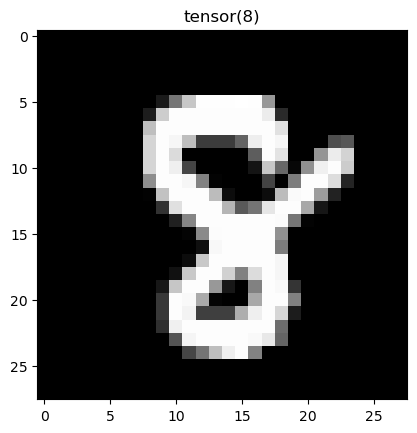

In [22]:
# Image
plt.figure()
plt.title(batch_y[0])
plt.imshow(batch_X[0,0], cmap='gray')
plt.show()

In [23]:
# use_cuda = False
#  if use_cuda and torch.cuda.is_available():
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)
# torch.cuda.empty_cache()

cuda:0


In [24]:

# VAE Model
class VAE(torch.nn.Module):
    def __init__(self, latent_dim=2, beta=1):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.beta = beta
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, 2, 1)
            ,torch.nn.ReLU()
            ,torch.nn.Conv2d(32, 64, 3, 2, 1)
            ,torch.nn.ReLU()
            ,torch.nn.Flatten()
            ,torch.nn.Linear(64*7*7, self.latent_dim*2)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, 64*7*7)
            ,torch.nn.ReLU()
            ,torch.nn.Unflatten(1, (64, 7, 7))
            ,torch.nn.ConvTranspose2d(64, 32, 4, 2, 1)
            ,torch.nn.ReLU()
            ,torch.nn.ConvTranspose2d(32, 1, 4, 2, 1)
        )
        
        self.generating = False
    
    def encode(self, x):
        return self.encoder(x)
    
    def reparameterize(self, mu, sigma):
        self.epsilon = torch.rand(mu.shape).to(mu.device)
        return mu + sigma * self.epsilon
        
    def decode(self, latent_sample, generating=None):
        output = self.decoder(latent_sample)
        
        generating = self.generating if generating is None else generating
        if generating:
            output = torch.sigmoid(output)
        return output
    
    def forward(self, x):
        self.latent_factors = self.encode(x)
        
        self.mu = self.latent_factors[:,:self.latent_dim]
        self.sigma = self.latent_factors[:,self.latent_dim:]
        
        self.latent_sample = self.reparameterize(self.mu, self.sigma)
        self.output = self.decode(self.latent_sample)
        return self.output

    def train(self):
        self.training = True
        self.generating = False
        
    def eval(self):
        self.training = False
        self.generating = False
    
    def generate(self):
        self.training = False
        self.generating = True

In [25]:
# sample_X = torch.rand(5,1,28,28)

vae = VAE()
vae(batch_X).shape
# vae(sample_X).shape
# vae.latent_factors.shape
# vae.mu.shape
# vae.sigma.shape
# vae.epsilon.shape
# vae.latent_sample.shape
# vae.random_generate


torch.Size([32, 1, 28, 28])

In [26]:
# # customize library ***---------------------
# import sys
# sys.path.append(r'../../★★ DS_Library')
# from DS_DeepLearning import EarlyStopping

import httpimport
remote_url = 'https://raw.githubusercontent.com/kimds929/'
with httpimport.remote_repo(f"{remote_url}/DS_Library/main/"):
    from DS_DeepLearning import EarlyStopping

# # ------------------------------------------
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

In [40]:
es = EarlyStopping(patience=100)

vae = VAE().to(device)

model = copy.deepcopy(vae)

In [41]:
loss_function = torch.nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

n_epochs = 50

In [42]:
train_losses = []
valid_losses = []
for e in range(n_epochs):
    start_time = time.time() # 시작 시간 기록
    model.train()
    train_epoch_loss = []
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()   # optimizer initialize
        model(batch_X.to(device))          # forward
        
        # calculate_loss
        loss_recon = - torch.sum( loss_function(model.output, batch_X.to(device)) )
        loss_kl = 0.5 * torch.sum(model.mu**2 + model.sigma**2 - torch.log(1e-8 + model.sigma**2) -1, dim=1)
        loss_ELBO = torch.mean(loss_recon - loss_kl)
        loss = - loss_ELBO
        
        loss.backward()         # backward
        optimizer.step()        # weight update
        
        with torch.no_grad():
            train_batch_loss = loss.to('cpu').detach().numpy()
            train_epoch_loss.append( train_batch_loss )
    
    # valid_set evaluation *
    valid_epoch_loss = []
    with torch.no_grad():
        model.eval() 
        for batch_X, batch_y in valid_loader:
            model(batch_X.to(device))          # forward
            loss_recon = - torch.sum( loss_function(model.output, batch_X.to(device)) )
            loss_kl = 0.5 * torch.sum(model.mu**2 + model.sigma**2 - torch.log(1e-8 + model.sigma**2) -1, dim=1)
            loss_ELBO = torch.mean(loss_recon - loss_kl)
            loss = - loss_ELBO
            
            valid_batch_loss = loss.to('cpu').detach().numpy()
            valid_epoch_loss.append( valid_batch_loss )
    
    with torch.no_grad():
        train_loss = np.mean(train_epoch_loss)
        valid_loss = np.mean(valid_epoch_loss)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time() # 종료 시간 기록
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # print(f'Epoch: {e + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        # print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):.3f}')
        # print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {np.exp(valid_loss):.3f}')
        # customize library ***---------------------
        early_stop = es.early_stop(score=valid_loss, reference_score=train_loss, save=model.state_dict(), verbose=2)
        if early_stop == 'break':
            break
        # ------------------------------------------

epoch: 1, valid_score: 5215.7, train_score: 5651.0 **optimum
epoch: 2, valid_score: 5024.2, train_score: 5109.0 **optimum
epoch: 3, valid_score: 5006.9, train_score: 4978.8 **optimum
epoch: 4, valid_score: 4946.6, train_score: 4906.4 **optimum
epoch: 5, valid_score: 4851.4, train_score: 4857.5 **optimum
epoch: 6, valid_score: 4819.9, train_score: 4821.0 **optimum
epoch: 7, valid_score: 4789.5, train_score: 4794.9 **optimum
epoch: 8, valid_score: 4788.1, train_score: 4772.4 **optimum
epoch: 9, valid_score: 4771.4, train_score: 4755.5 **optimum
epoch: 10, valid_score: 4808.3, train_score: 4740.7 **patience
epoch: 11, valid_score: 4764.1, train_score: 4727.8 **optimum
epoch: 12, valid_score: 4744.5, train_score: 4718.7 **optimum
epoch: 13, valid_score: 4766.3, train_score: 4705.9 **patience
epoch: 14, valid_score: 4740.7, train_score: 4697.2 **optimum
epoch: 15, valid_score: 4738.3, train_score: 4688.0 **optimum
epoch: 16, valid_score: 4792.8, train_score: 4682.8 **patience
epoch: 17, val

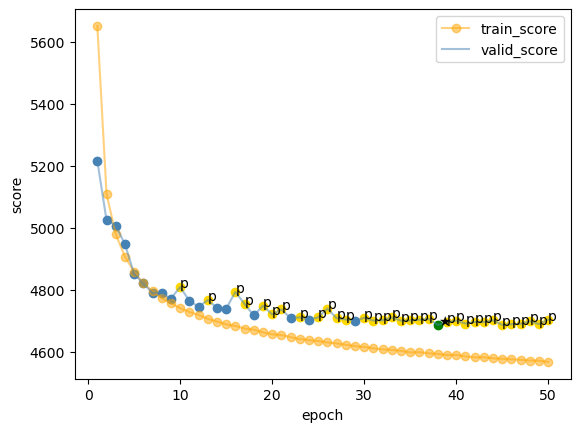

In [43]:
# customize early stopping library ***---------------------
es.plot     # early_stopping plot

In [44]:
vae.load_state_dict(es.optimum[2])

<All keys matched successfully>

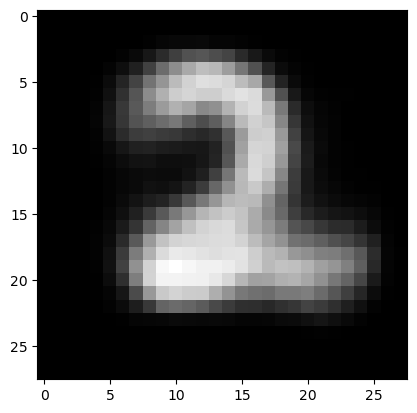

In [45]:
# Image Generate
position_vector = torch.Tensor([0,0]).unsqueeze(0).to(device)
with torch.no_grad():
    vae.generate()
    gen_output = vae.decode(position_vector)

plt.figure()
plt.imshow(gen_output[0,0].to('cpu').detach(), cmap='gray')
plt.show()

In [46]:
def image_map(h_v, w_v, decoder, digit_h=28, digit_w=28):
    """
    h_v : heigt_vector (ex. np.linsapce(-1, 1, 10))
    w_v : width_vector (ex. np.linsapce(-1, 1, 10))
    decoder : callable function model's generator (ex. model.generate )
    """
    n_h = len(h_v)
    n_w = len(w_v)
    
    map = torch.zeros((n_h*digit_h, n_w*digit_w))
    combinations = np.stack(np.meshgrid(h_v, w_v)).T.reshape(-1,2)
    for e, p in enumerate(combinations):
        position_vector = torch.Tensor(p).unsqueeze(0).to(device)
        with torch.no_grad():
            gen_output = decoder(position_vector)
            
        rs = (e // n_w) * digit_h
        cs = ((e - (e // n_h) * n_w) % n_w) * digit_w
        # print(e, p, rs/digit_h, cs/digit_w)
        map[rs:rs+digit_h, cs:cs+digit_w] = gen_output.squeeze()
        
    return map

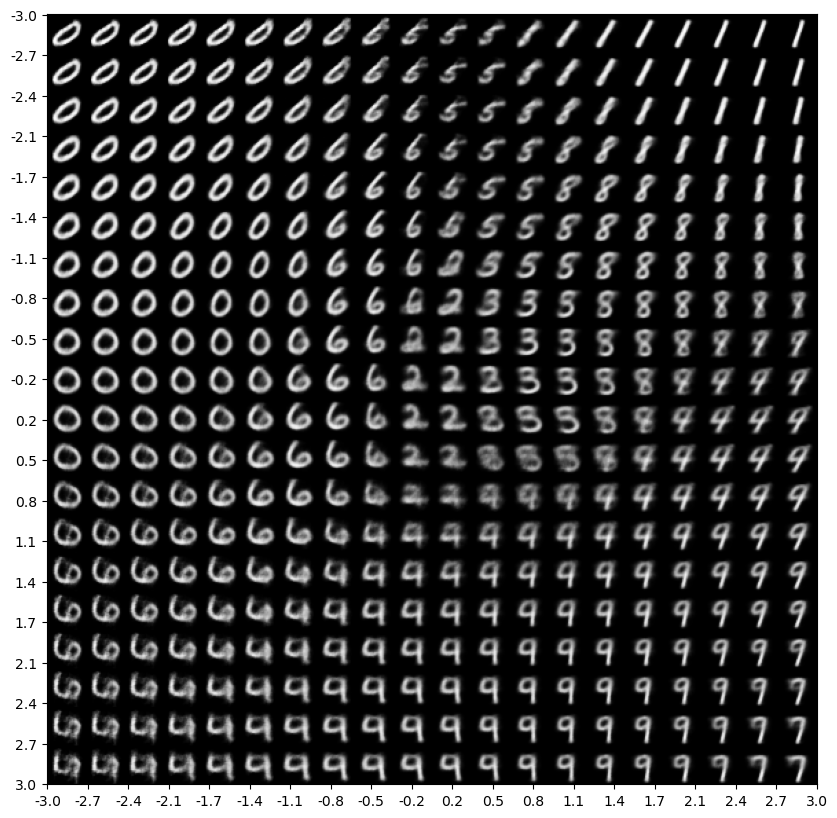

In [47]:
n_points = 20

x1 = np.linspace(-3, 3, n_points)
x2 = np.linspace(-3, 3, n_points)

vae.generate()
img_map = image_map(x1, x2, vae.decode)

plt.figure(figsize=(10,10))
plt.imshow(img_map, 'gray')
plt.xticks(np.linspace(0, 28*n_points, n_points), np.round(x1,1))
plt.yticks(np.linspace(0, 28*n_points, n_points), np.round(x1,1))
plt.show()